# Information Theory for Prediciton Markets - Accessory Notebook

## Code by Ian Joffe, see report for details

In Section 2 of my report, I discuss a multi-agent agreement game where the agents participate at a given time with uniform probability, or equivilently the number of announcments an agent makes is Poisson distributed and the waiting time between announcements is Exponential distributed. In Section 3, I discuss how the original paper's authors used an agreement game to learn about prediction markets, and I add that today's prediction markets are best described by the random participation variant of the agreement game. 

I want to examine whether bettors in real prediction markets actually participate uniformly over time. I use data from the real-money prediction market Kalshi for this assessment. Unfortunately, Kalshi does not offer data on orders placed by individual users, just the order book without trader IDs. But if each trader participates uniformly over time, then all trades occur uniformly over time, so we potentially can describe the quantity of and waiting times between all trades using the Poisson and Exponential. 

In [1]:
import numpy as np
import kalshi_python
from kalshi_python.models import *
import uuid

In [2]:
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels
import pymc3 as pm # requires arviz version 0.11.0

C:\Users\iijof\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


I'm using old markets accessible through the Kalshi demo API

In [3]:
config = kalshi_python.Configuration()
config.host = 'https://demo-api.kalshi.co/trade-api/v2'

In [4]:
# this is a demo only account and has no personal info or cashable money on it, but the reader is welcome to fund it :)
kalshi_api = kalshi_python.ApiInstance(
    email='ianjoffe@uchicago.edu',
    password='Linear-Sketch-2024!',
    configuration=config,
)

The Kalshi API only makes trade times available at the granularity of seconds, so markets with action more often than that can't be examined. Anyway, it would make sense for lower-frequency markets to have fewer total agents trading, and trades completed by real humans instead of high frequency trading bots. My report focuses on trades between a small or medium number of real humans, so I'll focus on markets with a medium trading volume. The following code retrieves information about such markets over periods of time. 

In [5]:
min_volume = 10
max_volume = 100

markets = [m for m in kalshi_api.get_markets(status="closed", limit=1000).markets 
    if (m.volume > min_volume and m.volume < max_volume)]

print("Number of Markets Examined:", len(markets))

Number of Markets Examined: 28


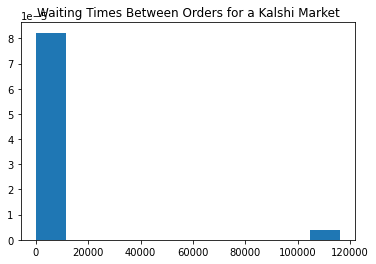

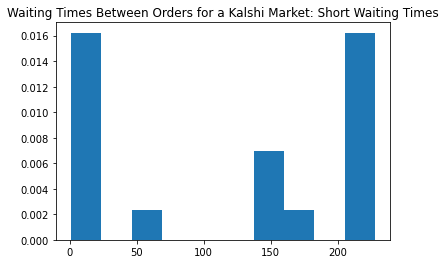

In [6]:
market_hisotry = kalshi_api.get_market_history(markets[0].ticker, min_ts=0)
order_times = np.array([order.ts for order in market_hisotry.history])
order_times = order_times - min(order_times)
waiting_times = np.diff(order_times)

plt.hist(waiting_times, density=True);
plt.title("Waiting Times Between Orders for a Kalshi Market");
plt.show();

plt.hist([t for t in waiting_times if t < 500], density=True);
plt.title("Waiting Times Between Orders for a Kalshi Market: Short Waiting Times");
plt.show();

In [7]:
print("Waiting Times: ", waiting_times)

Waiting Times:  [  6408    156  10027    143   1573    216    163     68    222      7
 116254    142      1    228      1    227      1    226      1    227
      1    223      1]


This doens't look like a Exponential distribution, so the hypothesis that it is Exponential distributed seems unlikley. We can look at the data's likelihood under an Exponential distribution.

In [8]:
# MLE fit for exponential distribution
expon_lambda_MLE = 1/np.mean(waiting_times)
print("MLE for Exponential's rate parameter:", expon_lambda_MLE)

MLE for Exponential's rate parameter: 0.00016847842011192827


The Exponential gives near-zero likelihood to at least one data point, as shown by the Log Likelihood

In [9]:
# likelihood of data under exponential fit
expon_loglik = np.sum(np.log(stats.expon.pdf(waiting_times, expon_lambda_MLE)))
print("Log Likelihood for Data under MLE-parameterized Exponential:", expon_loglik)

Log Likelihood for Data under MLE-parameterized Exponential: -inf


It's not just one data point either. Over half of the data has near zero likelihood under the Poisson with MLE $\lambda$. A likelihood ratio test against any comparable null distribution would conclude that the Poisson fit is useless. 

In [10]:
null_rate = sum(np.isclose(stats.expon.pdf(waiting_times, expon_lambda_MLE), 0)) / len(waiting_times)
print("Proportion of waiting times with near zero probability under MLE-parameterized Exponential:", round(null_rate, 2))

Proportion of waiting times with near zero probability under MLE-parameterized Exponential: 0.7


We get the same results for all the markets that we're considering. 

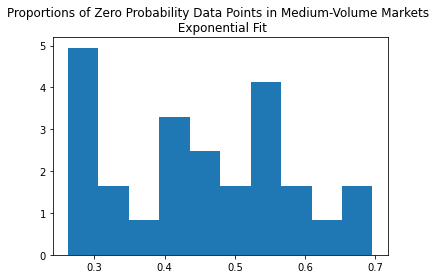

In [11]:
all_waiting_times = []
for m in markets:
    market_hisotry = kalshi_api.get_market_history(m.ticker, min_ts=0)
    order_times = np.array([order.ts for order in market_hisotry.history])
    order_times = order_times - min(order_times)
    all_waiting_times.append(np.diff(order_times))

all_lambdas = [1/np.mean(times) for times in all_waiting_times]
all_null_rates = [sum(np.isclose(stats.expon.pdf(all_waiting_times[i], all_lambdas[i]), 0)) /
                  len(all_waiting_times[i]) for i in range(len(all_waiting_times))]


plt.hist(all_null_rates, density=True);
plt.title("Proportions of Zero Probability Data Points in Medium-Volume Markets \n Exponential Fit");

It's possible that the only issue with the Exponential distribution is overdispersion, so adding a second parameter would make a much better fit. Therefore, we consider fitting using the Gamma distribution. We use method of moments since the Gamma doesn't have a closed form MLE. 

In [12]:
gamma_alpha_MOM = np.mean(waiting_times)**2 / np.var(waiting_times)
gamma_beta_MOM = np.var(waiting_times) / np.mean(waiting_times)
gamma_loglik = np.sum(np.log(stats.gamma.pdf(waiting_times, a=gamma_alpha_MOM, scale=1/gamma_beta_MOM)))

print("MoM-estimated Gamma Log Likelihood:", gamma_loglik)

MoM-estimated Gamma Log Likelihood: -inf


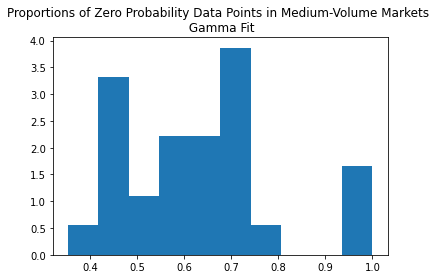

In [13]:
all_alphas = [np.mean(times)**2 / np.var(times) for times in all_waiting_times]
all_betas = [np.var(times) / np.mean(times) for times in all_waiting_times]
all_null_rates = [sum(np.isclose(stats.gamma.pdf(all_waiting_times[i], a=gamma_alpha_MOM, scale=1/gamma_beta_MOM), 0)) /
                  len(all_waiting_times[i]) for i in range(len(all_waiting_times))]


plt.hist(all_null_rates, density=True);
plt.title("Proportions of Zero Probability Data Points in Medium-Volume Markets \n Gamma Fit");

The Gamma fit is no better than the Exponential, and no reasonable test would declare it a strong fit at all. So it turns out, the behavior of humans on markets is more complex than one or two parameters can describe! One suggestion is that there is reason to belive that action in prediction markets may be clustered. An event can spark many people to want to update their predictions quickly, or a new prediction may cause a change in the market that causes other bettors to engage and put it back in equilibrium. It may be worth investigating distributions related to Hawkes processes, to see if its self-excitatory nature can inspire a good fit. 

Upon looking closer at the data, one note I'd like to make is that many of the markets are highly similar. For example, one is to predict whether S&P 500 hits 5100 by a date, and another is to see if it hits 5105. Users often will bet on these markets right after one another. So if one would like to consider this a study of just a few markets rather than of 28, that would be very fair, and arguably a more accurate interpretation. 

In the future, I hope to be able to use data from a prediction market that includes the IDs of invdividuals who place orders. Perhaps some users can be modeled with Exponential distributions, while others (such as bots) cannot. Examining differences between individuals' rates could also be insightful. 